In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/sampleSubmission.csv
/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip


# 1. import and Load data

In [96]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import Image
import warnings

warnings.filterwarnings('ignore')

In [3]:
sub = pd.read_csv("/kaggle/input/word2vec-nlp-tutorial/sampleSubmission.csv")
sub

,id,sentiment
0,12311_10,0
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,0
...,...,...
24995,2155_10,0
24996,59_10,0
24997,2531_1,0
24998,7772_8,0


In [4]:
test = pd.read_table("/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip")
train = pd.read_table("/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip")

In [5]:
train

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
...,...,...,...
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...


In [6]:
test

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...
...,...,...
24995,2155_10,"Sony Pictures Classics, I'm looking at you! So..."
24996,59_10,I always felt that Ms. Merkerson had never got...
24997,2531_1,I was so disappointed in this movie. I am very...
24998,7772_8,"From the opening sequence, filled with black a..."


# 2. Function

In [7]:
def graph(history):
    '''
    train, valid set 으로 모델이 학습한 acc, val_acc, loss, val_loss 를 에포크에 따라 추이를 파악해보는 함수.
    몇 번째 학습에서 과적합이 되는지, 혹은 학습이 잘 되고 있는지 확인.
    '''
    plt.style.use('default')
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(9,4))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'b', label = f'Training acc : {acc[-1]:.3f}')
    plt.plot(epochs, val_acc, 'r', label = f'Validation acc : {val_acc[-1]:.3f}')
    plt.title('Training and Validation acc')
    plt.xlabel(f'total epochs : {len(acc)}')
    plt.ylabel('acc score')
    plt.legend(loc='best')
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'b', label = f'Training loss : {loss[-1]:.3f}')
    plt.plot(epochs, val_loss, 'r', label = f'Validation loss : {val_loss[-1]:.3f}')
    plt.title('Training and Validation loss')
    plt.xlabel(f'total epochs : {len(loss)}')
    plt.ylabel('loss')
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show();

In [61]:
def load_embedding(path):
    '''
    pretrained embedding 을 불러오는 함수
    '''
    embeddings = {}
    with open(path) as f:
        for i in f:
            value = i.rstrip().split()
            embeddings[value[0]] = np.asarray(value[1:], dtype='float32')
    return embeddings

In [62]:
def filter_embedding(embeddings, word_index, vocab_size, dim=300):
    '''
    불러온 pretrained embedding 과 현재 데이터에서 학습한 token 사이에 일치하는 단어만 추출하는 filtering 함수
    '''
    embedding_matrix = np.zeros((vocab_size, dim))
    for word, i in word_index.items():
        vector = embeddings.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix

# 3. Description

### General

In this tutorial competition, we dig a little "deeper" into sentiment analysis. Google's Word2Vec is a deep-learning inspired method that focuses on the meaning of words. Word2Vec attempts to understand meaning and semantic relationships among words. It works in a way that is similar to deep approaches, such as recurrent neural nets or deep neural nets, but is computationally more efficient. This tutorial focuses on Word2Vec for sentiment analysis.

Sentiment analysis is a challenging subject in machine learning. People express their emotions in language that is often obscured by sarcasm, ambiguity, and plays on words, all of which could be very misleading for both humans and computers. There's another Kaggle competition for movie review sentiment analysis. In this tutorial we explore how Word2Vec can be applied to a similar problem.

Deep learning has been in the news a lot over the past few years, even making it to the front page of the New York Times. These machine learning techniques, inspired by the architecture of the human brain and made possible by recent advances in computing power, have been making waves via breakthrough results in image recognition, speech processing, and natural language tasks. Recently, deep learning approaches won several Kaggle competitions, including a drug discovery task, and cat and dog image recognition.

### Evaluation

Metric
Submissions are judged on area under the `ROC curve`.

* ROC curve : can use loss with categorical_crossentropy

### Data Set

The labeled data set consists of 50,000 IMDB `movie reviews`, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. The 25,000 review labeled training set does not include any of the same movies as the 25,000 review test set. In addition, there are another 50,000 IMDB reviews provided without any rating labels.

* 영화 리뷰라는 것을 감안하기

# 4. EDA

In [10]:
train['sentiment'].value_counts() # binary classification and 50:50 ratio of label

1    12500
0    12500
Name: sentiment, dtype: int64

In [11]:
len(train), len(test) # train 과 test set 의 길이도 같다.

(25000, 25000)

In [12]:
# 전반적으로 글을 살펴보자 (길이, 패턴 등)
train['review'].loc[0]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [13]:
train['review'].loc[10]

'What happens when an army of wetbacks, towelheads, and Godless Eastern European commies gather their forces south of the border? Gary Busey kicks their butts, of course. Another laughable example of Reagan-era cultural fallout, Bulletproof wastes a decent supporting cast headed by L Q Jones and Thalmus Rasulala.'

In [14]:
train['review'].loc[100]

"There is a uk edition to this show which is rather less extravagant than the US version. The person concerned will get a new kitchen or perhaps bedroom and bathroom and is wonderfully grateful for what they have got. The US version of this show is everything that reality TV shouldn't be. Instead of making a few improvements to a house which the occupants could not afford or do themselves the entire house gets rebuilt. I do not know if this show is trying to show what a lousy welfare system exists in the US or if you beg hard enough you will receive. The rather vulgar product placement that takes place, particularly by Sears, is also uncalled for. Rsther than turning one family in a deprived area into potential millionaires, it would be far better to help the community as a whole where instead of spending the hundreds of thousands of dollars on one home, build something for the whole community ..... perhaps a place where diy and power tools can be borrowed and returned along with build

In [15]:
train['review'].loc[1000]

"I watched this movie really late last night and usually if it's late then I'm pretty forgiving of movies. Although I tried, I just could not stand this movie at all, it kept getting worse and worse as the movie went on. Although I know it's suppose to be a comedy but I didn't find it very funny. It was also an especially unrealistic, and jaded portrayal of rural life. In case this is what any of you think country life is like, it's definitely not. I do have to agree that some of the guy cast members were cute, but the french guy was really fake. I do have to agree that it tried to have a good lesson in the story, but overall my recommendation is that no one over 8 watch it, it's just too annoying."

In [16]:
train['review'].loc[10000]

'I would have rated the series a perfect 10 for outstanding and consistently high quality story and character development had it not been for the last episode of Season 10! <br /><br />The final episode of the 10th season \\Unending\\", where (it would certainly appear that) the Asgard have been killed-off in a very rushed, unconvincing and very unceremonious fashion, left me in disbelief! <br /><br />From the extremely rushed end of the series, it\'s obvious that many of the story arcs were originally scheduled to occur over at least one more season. My guess would be that they rapidly accelerated these stories to position the Stargate SG-1 franchise for the two upcoming direct-to-DVD moves!<br /><br />Unless the Asgard return in a future SG-1 movie (with a very good explanation of the \\"apparent\\" extinction), I think that the fans have been cheated with a poor clean-up of loose-ends!<br /><br />Poor end to an otherwise brilliant sci-fi series."'

* 길이가 제각각이다. 매우 긴 글도 있고 짧은 글도 있다.
* html 형식에 따른 문법이 포함된 글도 있다. 

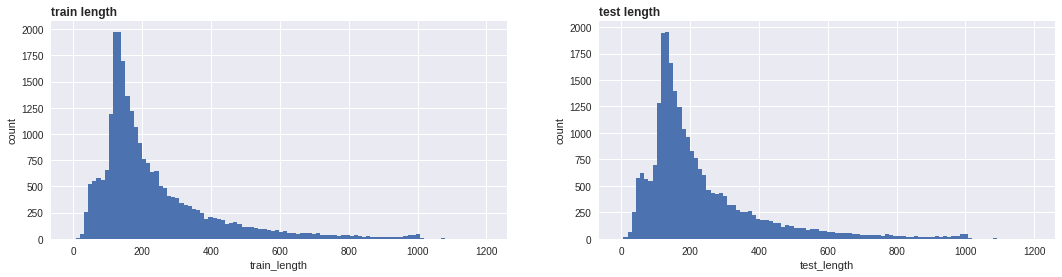

In [48]:
train_eda = train.copy()
test_eda = test.copy()
train_eda['length'] = train_eda['review'].apply(lambda x: len(x.split()))
test_eda['length'] = test_eda['review'].apply(lambda x: len(x.split()))

plt.style.use('seaborn')
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.hist(train_eda['length'], 
         bins=100, 
         range=(-5,1200))
plt.xlabel('train_length')
plt.ylabel('count')
plt.title('train length', 
          fontweight='bold', 
          loc='left')

plt.subplot(122)
plt.hist(test_eda['length'], 
         bins=100, 
         range=(-5,1200));
plt.xlabel('test_length')
plt.ylabel('count')
plt.title('test length', 
          fontweight='bold', 
          loc='left')

plt.show();

# 5. Preprocessing text

In [19]:
allData = pd.concat([train, test])
allData

,id,sentiment,review
0,5814_8,1.0,With all this stuff going down at the moment w...
1,2381_9,1.0,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0.0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0.0,It must be assumed that those who praised this...
4,9495_8,1.0,Superbly trashy and wondrously unpretentious 8...
...,...,...,...
24995,2155_10,NaN,"Sony Pictures Classics, I'm looking at you! So..."
24996,59_10,NaN,I always felt that Ms. Merkerson had never got...
24997,2531_1,NaN,I was so disappointed in this movie. I am very...
24998,7772_8,NaN,"From the opening sequence, filled with black a..."


In [32]:
# Tokenzier 를 사용한 텍스트 토큰화
tk = Tokenizer(lower=True)
tk.fit_on_texts(allData['review'])
len(tk.word_index)

124252

In [49]:
# tk.word_index 

In [50]:
# Tokenzier 로 텍스트를 토큰화
all_text = tk.texts_to_sequences(allData['review'])
# all_text

In [25]:
# pad_sequences 로 모두 같은 길이로 패딩시킨다.
# 앞쪽에 패딩을 준다. 일반적으로 RNN계열은 최근 데이터(뒤쪽 데이터)를 마지막으로 학습하여 가중치 할당이 높게 되기 때문.
all_pad = pad_sequences(all_text, maxlen=None, padding='pre')
all_pad

array([[   0,    0,    0, ...,   21,    1, 1598],
       [   0,    0,    0, ...,   26,   92, 5686],
       [   0,    0,    0, ..., 1305,    4, 5344],
       ...,
       [   0,    0,    0, ...,  289,   64,  566],
       [   0,    0,    0, ...,   22,  112, 9811],
       [   0,    0,    0, ...,    5,   12,   27]], dtype=int32)

In [28]:
train_pad = all_pad[:len(train)]
test_pad = all_pad[len(train):]
train_pad.shape, test_pad.shape

((25000, 2493), (25000, 2493))

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(train_pad,
                                                      train['sentiment'],
                                                      test_size=0.2,
                                                      stratify=train['sentiment'],
                                                      random_state=12)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((20000, 2493), (5000, 2493), (20000,), (5000,))

# 6. Modeling

### 1. text 및 sequence 학습에 좋은 RNN 계열(SimpleRNN, LSTM, GRU)로 텍스트 학습을 해볼 것이다.  

### 2. 2가지 방법으로 학습해본다.  
    1) `Embedding 층 + LSTM 으로 설계` : LSTM 의 경우 return_sequences 옵션을 주어 앞의 내용을 더 잘 기억할 수 있도록 해준다.  
    2) `Pretrained Embedding` : Embedding 에 미리 학습된 embedding 단어 및 가중치 행렬을 불러와 학습시킨다.  
        : GloVe, Word2Vec, fasttext 등이 있지만, facebook 에서 추출한 단어로 학습된 fasttext로 학습시켜볼 것이다.  
        
### 3. StratifyKFold  
    앞선 방법으로 층을 설계 했지만, validation data 를 위해서 train_test_split 를 사용하게 되면    
    validation_data 에 해당하는 데이터는 train data set으로 학습하지 못한다는 단점이 존재한다.   
    
    scikit-learn 의 StratifyKFold 를 사용하여 전체 데이터를 모두 균등하게 학습시켜 예측하는데 활용해보자.

## 6-1) 기본 Embeeding 층 + LSTM 층 실험

In [74]:
model = Sequential()

model.add(Embedding(len(tk.word_index)+1, 128, input_length=train_pad.shape[1]))
model.add(LSTM(64, return_sequences=True)) # return_sequences = True 옵션을 준다. 전체 시퀀스에 대한 결과값이 추출된다.
model.add(LSTM(64, return_sequences=False)) # return_sequenes = False : 이 이후에 Flatten 층을 주지 않아도 된다. 마지막 결과값만 추출된다.
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2493, 128)         15904384  
_________________________________________________________________
lstm_10 (LSTM)               (None, 2493, 64)          49408     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 66        
Total params: 15,988,962
Trainable params: 15,988,962
Non-trainable params: 0
__________________________________________

In [75]:
es = EarlyStopping(patience=3, 
                   monitor='val_loss',
                   verbose=1)

mc = ModelCheckpoint('best.h5',
                     monitor='val_loss',
                     save_best_only=True, 
                     verbose=1)

rp = ReduceLROnPlateau(patience=2, 
                       verbose=1, 
                       monitor='val_loss',
                       min_lr=0.0001,
                       factor=0.5)

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(1e-3),
              metrics=['acc'])

In [76]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_valid, y_valid),
                    callbacks=[es,mc,rp])

Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 0.4213 - acc: 0.8059
Epoch 00001: val_loss improved from inf to 0.33952, saving model to best.h5
625/625 [==============================] - 271s 434ms/step - loss: 0.4213 - acc: 0.8059 - val_loss: 0.3395 - val_acc: 0.8646
Epoch 2/5
625/625 [==============================] - ETA: 0s - loss: 0.1995 - acc: 0.9280
Epoch 00002: val_loss improved from 0.33952 to 0.32770, saving model to best.h5
625/625 [==============================] - 271s 433ms/step - loss: 0.1995 - acc: 0.9280 - val_loss: 0.3277 - val_acc: 0.8704
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 0.1269 - acc: 0.9560
Epoch 00003: val_loss did not improve from 0.32770
625/625 [==============================] - 271s 433ms/step - loss: 0.1269 - acc: 0.9560 - val_loss: 0.3715 - val_acc: 0.8594
Epoch 4/5
625/625 [==============================] - ETA: 0s - loss: 0.0576 - acc: 0.9812
Epoch 00004: val_loss did not improve from 0.32770

Epoch 

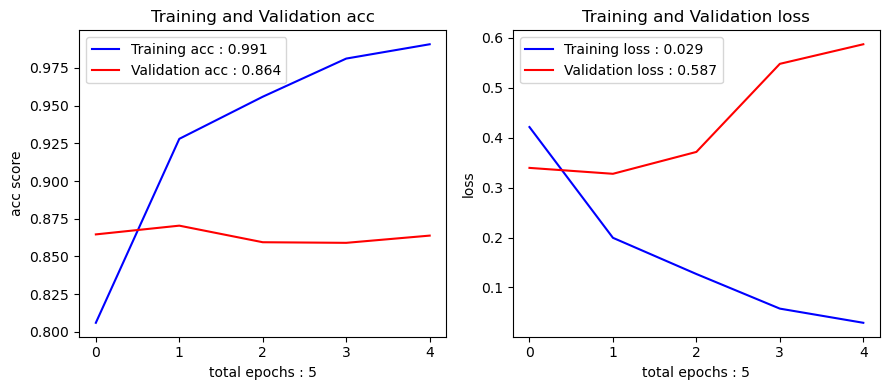

In [77]:
graph(history)

* epochs 3회차부터 과적합되고 있다.

In [78]:
model.load_weights('best.h5')
result = model.predict(test_pad)
result

array([[0.00391295, 0.9960871 ],
       [0.9924114 , 0.0075887 ],
       [0.6726679 , 0.3273321 ],
       ...,
       [0.98309374, 0.01690622],
       [0.01311204, 0.986888  ],
       [0.96268547, 0.03731453]], dtype=float32)

In [79]:
sub['sentiment'] = result[:,1]
sub

,id,sentiment
0,12311_10,0.996087
1,8348_2,0.007589
2,5828_4,0.327332
3,7186_2,0.307510
4,12128_7,0.817170
...,...,...
24995,2155_10,0.976470
24996,59_10,0.930566
24997,2531_1,0.016906
24998,7772_8,0.986888


In [80]:
sub.to_csv("base_model.csv", index=0)
print('Done!')

Done!


* base_model : 0.93375 (Roc_curve)

## 6-2) Pretrained embedding : fasttext embedding

* 사전 학습된 임베딩 추가하여 학습하기 : facebook 기반, 300차원의 임베딩
* 비교를 위해 옵션은 같은 상태에서 학습시켜본다. 

https://www.kaggle.com/yekenot/fasttext-crawl-300d-2m

In [81]:
# pretrained Embedding 추가하기
path = "../input/fasttext/crawl-300d-2M.vec"
embeddings = load_embedding(path)

In [82]:
# pretrained embedding 과 현재 데이터의 Tokenizer 사이에 둘 다 존재하는 단어의 임베딩만 추출하기
embedding_matrix = filter_embedding(embeddings, tk.word_index, len(tk.word_index)+1, 300)
embedding_matrix.shape

(124253, 300)

In [87]:
model = Sequential()

model.add(Embedding(len(tk.word_index)+1, 
                    300, 
                    input_length=train_pad.shape[1],
                    weights=[embedding_matrix], # 사전 학습된 embedding 활용
                    trainable=False)) # 사전 학습된 embedding 이 변하지 않고 그대로 학습에 이용할 수 있도록 옵션 설정

model.add(LSTM(64, return_sequences=True)) # return_sequences = True 옵션을 준다. 전체 시퀀스에 대한 결과값이 추출된다.
model.add(LSTM(64, return_sequences=False)) # return_sequenes = False : 이 이후에 Flatten 층을 주지 않아도 된다. 마지막 결과값만 추출된다.
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 2493, 300)         37275900  
_________________________________________________________________
lstm_14 (LSTM)               (None, 2493, 64)          93440     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 66        
Total params: 37,404,510
Trainable params: 128,610
Non-trainable params: 37,275,900
____________________________________

In [88]:
es = EarlyStopping(patience=3, 
                   monitor='val_loss',
                   verbose=1)

mc = ModelCheckpoint('best.h5',
                     monitor='val_loss',
                     save_best_only=True, 
                     verbose=1)

rp = ReduceLROnPlateau(patience=2, 
                       verbose=1, 
                       monitor='val_loss',
                       min_lr=0.0001,
                       factor=0.5)

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(1e-3),
              metrics=['acc'])

In [89]:
history2 = model.fit(X_train, y_train,
                     epochs=20,
                     batch_size=32,
                     validation_data=(X_valid, y_valid),
                     callbacks=[es,mc,rp])

Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 0.4391 - acc: 0.8000
Epoch 00001: val_loss improved from inf to 0.42510, saving model to best.h5
625/625 [==============================] - 136s 217ms/step - loss: 0.4391 - acc: 0.8000 - val_loss: 0.4251 - val_acc: 0.8244
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 0.3528 - acc: 0.8547
Epoch 00002: val_loss did not improve from 0.42510
625/625 [==============================] - 131s 209ms/step - loss: 0.3528 - acc: 0.8547 - val_loss: 0.5380 - val_acc: 0.8160
Epoch 3/20
625/625 [==============================] - ETA: 0s - loss: 0.3522 - acc: 0.8533
Epoch 00003: val_loss improved from 0.42510 to 0.29980, saving model to best.h5
625/625 [==============================] - 134s 215ms/step - loss: 0.3522 - acc: 0.8533 - val_loss: 0.2998 - val_acc: 0.8778
Epoch 4/20
625/625 [==============================] - ETA: 0s - loss: 0.3355 - acc: 0.8601
Epoch 00004: val_loss did not improve from 0.29980
625

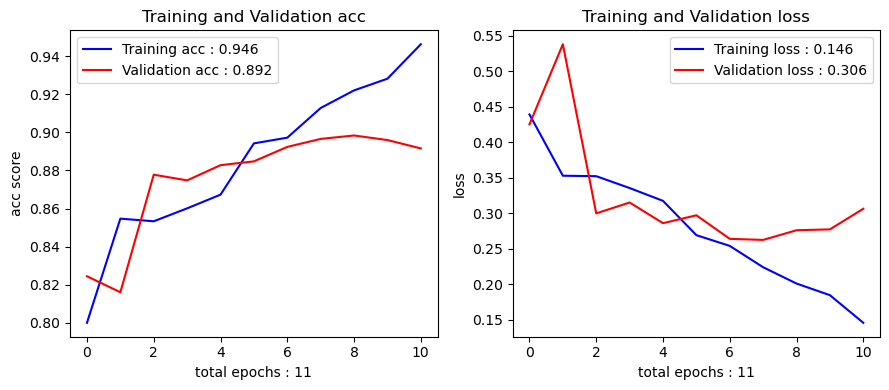

In [91]:
graph(history2)

In [92]:
model.load_weights('best.h5')
result = model.predict(test_pad)
result

array([[0.00270467, 0.9972953 ],
       [0.9976585 , 0.00234148],
       [0.5927756 , 0.40722442],
       ...,
       [0.96313566, 0.03686432],
       [0.0049081 , 0.9950919 ],
       [0.3934399 , 0.6065602 ]], dtype=float32)

In [93]:
sub['sentiment'] = result[:,1]
sub

,id,sentiment
0,12311_10,0.997295
1,8348_2,0.002341
2,5828_4,0.407224
3,7186_2,0.009001
4,12128_7,0.834909
...,...,...
24995,2155_10,0.908818
24996,59_10,0.988004
24997,2531_1,0.036864
24998,7772_8,0.995092


In [94]:
sub.to_csv("pretrained_model.csv", index=0)
print('Done!')

Done!


* base model score : 0.93375 
* pretrained model score : 0.96405 
* 학습 정확도(ROC_curve) 에서 향상을 보였다.

## 6-3) StratifyKFold

    앞선 방법으로 층을 설계 했지만, validation data 를 위해서 train_test_split 를 사용하게 되면    
    validation_data 에 해당하는 데이터는 train data set으로 학습하지 못한다는 단점이 존재한다.   
    
    scikit-learn 의 StratifyKFold 를 사용하여 전체 데이터를 모두 균등하게 학습시켜 예측하는데 활용해보자.

In [98]:
%%time

# StratifyKFold
skf = StratifiedKFold(n_splits=5, 
                      random_state=13, 
                      shuffle=True)

y = train['sentiment']

result = 0

for train_index, valid_index in skf.split(train_pad, y): 
    X_train, y_train = train_pad[train_index], y[train_index]
    X_valid, y_valid = train_pad[valid_index], y[valid_index]
    
    # model layer 쌓기
    model = Sequential()
    model.add(Embedding(len(tk.word_index)+1, 
                        300, 
                        input_length=train_pad.shape[1],
                        weights=[embedding_matrix], # 사전 학습된 embedding 활용
                        trainable=False)) # 사전 학습된 embedding 이 변하지 않고 그대로 학습에 이용할 수 있도록 옵션 설정
    model.add(LSTM(64, return_sequences=True)) # return_sequences = True 옵션을 준다. 전체 시퀀스에 대한 결과값이 추출된다.
    model.add(LSTM(64, return_sequences=False)) # return_sequenes = False : 이 이후에 Flatten 층을 주지 않아도 된다. 마지막 결과값만 추출된다.
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    
    # callbacks 함수 설정
    es = EarlyStopping(patience=3, 
                       monitor='val_loss',
                       verbose=1)

    mc = ModelCheckpoint('best.h5',
                         monitor='val_loss',
                         save_best_only=True, 
                         verbose=1)

    rp = ReduceLROnPlateau(patience=2, 
                           verbose=1, 
                           monitor='val_loss',
                           min_lr=0.0001,
                           factor=0.5)

    # model.compile
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=Adam(1e-3),
                  metrics=['acc'])

    # 모델 학습시키기
    model.fit(X_train, y_train,
              epochs=20, # 
              batch_size=32,
              validation_data=(X_valid, y_valid),
              callbacks=[es,mc,rp])
    
    # 모델 불러오기
    model.load_weights('best.h5')
    result += model.predict(test_pad)/5 # split 횟수만큼 나눈 값을 더해주기
    
print('Complete StratifyKFold Training and Prediction!')

Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 0.4637 - acc: 0.7843- ETA: 1s - loss: 0.4650 - acc:
Epoch 00001: val_loss improved from inf to 0.38989, saving model to best.h5
625/625 [==============================] - 133s 214ms/step - loss: 0.4637 - acc: 0.7843 - val_loss: 0.3899 - val_acc: 0.8266
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 0.4334 - acc: 0.8002
Epoch 00002: val_loss did not improve from 0.38989
625/625 [==============================] - 134s 214ms/step - loss: 0.4334 - acc: 0.8002 - val_loss: 0.4020 - val_acc: 0.8022
Epoch 3/20
625/625 [==============================] - ETA: 0s - loss: 0.3405 - acc: 0.8617
Epoch 00003: val_loss improved from 0.38989 to 0.31335, saving model to best.h5
625/625 [==============================] - 134s 214ms/step - loss: 0.3405 - acc: 0.8617 - val_loss: 0.3134 - val_acc: 0.8630
Epoch 4/20
625/625 [==============================] - ETA: 0s - loss: 0.2942 - acc: 0.8819
Epoch 00004: val_loss i

Epoch 7/20
625/625 [==============================] - ETA: 0s - loss: 0.2325 - acc: 0.9085
Epoch 00007: val_loss did not improve from 0.24719
625/625 [==============================] - 134s 214ms/step - loss: 0.2325 - acc: 0.9085 - val_loss: 0.3149 - val_acc: 0.8860
Epoch 8/20
625/625 [==============================] - ETA: 0s - loss: 0.2147 - acc: 0.9198
Epoch 00008: val_loss did not improve from 0.24719

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 [==============================] - 134s 215ms/step - loss: 0.2147 - acc: 0.9198 - val_loss: 0.2558 - val_acc: 0.8990
Epoch 9/20
625/625 [==============================] - ETA: 0s - loss: 0.1943 - acc: 0.9284
Epoch 00009: val_loss improved from 0.24719 to 0.24283, saving model to best.h5
625/625 [==============================] - 133s 214ms/step - loss: 0.1943 - acc: 0.9284 - val_loss: 0.2428 - val_acc: 0.9016
Epoch 10/20
625/625 [==============================] - ETA: 0s - loss: 0.1825 - acc: 0.93

Epoch 10/20
625/625 [==============================] - ETA: 0s - loss: 0.1747 - acc: 0.9300
Epoch 00010: val_loss did not improve from 0.26355
625/625 [==============================] - 134s 215ms/step - loss: 0.1747 - acc: 0.9300 - val_loss: 0.2786 - val_acc: 0.8978
Epoch 00010: early stopping
Complete StratifyKFold Training and Prediction!
CPU times: user 1h 59min 44s, sys: 13min 23s, total: 2h 13min 7s
Wall time: 2h 13min 31s


In [103]:
sub['sentiment'] = result[:,1]
sub

,id,sentiment
0,12311_10,0.997575
1,8348_2,0.004825
2,5828_4,0.358875
3,7186_2,0.036029
4,12128_7,0.738379
...,...,...
24995,2155_10,0.819213
24996,59_10,0.991795
24997,2531_1,0.063983
24998,7772_8,0.996052


In [104]:
sub.to_csv("stratify_model.csv", index=0)

|model | score | rank |
|:-:|:-:|:-:|
|base model | 0.93375 |206 / 577|
|pretrained model | 0.96405 |42 / 577|
|stratify model | 0.97156|10 / 577|